### GenAI Academy - M2 | Análise e Processamento de Dados - Case: Predição de Casos de AVC

___

### Introdução

Vamos trabalhar com um dataset de informações sobre pacientes, manipulando e processando os dados de forma preparatória para uma posterior etapa de treinamento de modelo preditivo da condição clínica de AVC.


### Etapas
#### 1. Construção do cenário
- **Importação do dataset**

- **Introdução de Inconsistências no Conjunto**
    - Vamos fazer algumas alterações no nosso dataset, anulando e tornando inconsistentes alguns dados, com o objetivo de simular um cenário onde temos um conjunto minimamente defeituoso e que necessita de medidas de adequação.
    
- **Criação do Banco de Dados**
    - Nosso objetivo é trabalhar com dados originados de um banco, então vamos normalizar a estrutura do nosso dataset e criar nossa base utilizando SQLite.

#### 2. Extração e Análise Exploratória de Dados
- **Extração de Dados**
    - Vamos extrair os dados do nosso banco.
- **Tratamento de Inconsistências**
    - Ajustaremos valores nulos e incongruentes.
- **Análise Exploratória**
    - Iremos utilizar ferramentas para compreender a estrutura dos dados com os quais vamos trabalhar e entender as nossas features.

#### 3. Pré-processamento
- **Padronização e Normalização**
    - Vamos padronizar as features do nosso conjunto.
- **Divisão do Conjunto**
    - Divisão entre dados de treino e teste.
#### 4. Treinamento e Validação
- **Treinamento do Modelo**
    - Treinamento do modelo com o conjunto de features extraídas.
- **Validação**
    - Verificação da performance do modelo criado.

- Obs: Nessa atividade, não vamos trabalhar o nosso modelo, encerraremos com a inserção dos dados inicialmente pré-processados.
___

In [766]:
# Importando Bibliotecas 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sqlite3
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [767]:
# [1. Construção do Cenário - Importação do Dataset]

dataset = pd.read_csv("dataset.csv")

In [768]:
# [1. Construção do Cenário - Introdução de Inconsistências no Conjunto]

# Função para introduzir valores faltantes
def introduce_missing_values(df, column, percent):
    n_missing = int(len(df) * percent)
    missing_indices = np.random.choice(df.index, n_missing, replace=False)
    df.loc[missing_indices, column] = np.nan

# Função para introduzir inconsistências
def introduce_inconsistencies(df, column, percent):
    n_inconsistent = int(len(df) * percent)
    inconsistent_indices = np.random.choice(df.index, n_inconsistent, replace=False)
    # Introduzir outliers atribuindo valores altos aleatórios
    df.loc[inconsistent_indices, column] = df[column].mean() + df[column].std() * 10
  

# Introduzir valores faltantes em 'age', 'avg_glucose_level' e 'smoking_status'
introduce_missing_values(dataset, 'age', 0.01)
introduce_missing_values(dataset, 'smoking_status', 0.01)

# Introduzir inconsistências em 'bmi' (outliers) e 'work_type' (tipos incorretos)
introduce_inconsistencies(dataset, 'bmi', 0.01)
introduce_inconsistencies(dataset, 'age', 0.01)

dataset.to_csv('modified_dataset.csv', index=False)

In [769]:
# [1. Construção do Cenário - Criação do banco de dados]

db_path = 'patient_data.db'

# Deletar o arquivo do banco de dados se ele já existir
if os.path.exists(db_path):
    os.remove(db_path)

conn = sqlite3.connect('patient_data.db')
cursor = conn.cursor()

# Criar tabelas de referência
cursor.execute('''
CREATE TABLE GENDER (
    ID INTEGER PRIMARY KEY AUTOINCREMENT,
    DESCRIPTION TEXT NOT NULL
)
''')

cursor.execute('''
CREATE TABLE WORK_TYPE (
    ID INTEGER PRIMARY KEY AUTOINCREMENT,
    DESCRIPTION TEXT NOT NULL
)
''')

cursor.execute('''
CREATE TABLE RESIDENCE_TYPE (
    ID INTEGER PRIMARY KEY AUTOINCREMENT,
    DESCRIPTION TEXT NOT NULL
)
''')

cursor.execute('''
CREATE TABLE SMOKING_STATUS (
    ID INTEGER PRIMARY KEY AUTOINCREMENT,
    DESCRIPTION TEXT NOT NULL
)
''')

# Criar tabela principal
cursor.execute('''
CREATE TABLE PATIENT (
    ID INTEGER PRIMARY KEY,
    GENDER_ID INTEGER,
    WORK_TYPE_ID INTEGER,
    RESIDENCE_TYPE_ID INTEGER,
    AGE REAL,
    HYPERTENSION INTEGER,
    HEART_DISEASE INTEGER,
    EVER_MARRIED TEXT,
    AVG_GLUCOSE_LEVEL REAL,
    BMI REAL,
    SMOKING_STATUS_ID INTEGER,
    STROKE INTEGER,
    FOREIGN KEY (GENDER_ID) REFERENCES GENDER(ID),
    FOREIGN KEY (WORK_TYPE_ID) REFERENCES WORK_TYPE(ID),
    FOREIGN KEY (RESIDENCE_TYPE_ID) REFERENCES RESIDENCE_TYPE(ID),
    FOREIGN KEY (SMOKING_STATUS_ID) REFERENCES SMOKING_STATUS(ID)
)
''')

# Função para inserir valores únicos em uma tabela de referência
def insert_unique_values(df, column, table):
    unique_values = df[column].dropna().unique()
    for value in unique_values:
        cursor.execute(f"INSERT INTO {table} (DESCRIPTION) VALUES (?)", (value,))
    conn.commit()

# Inserir valores únicos nas tabelas de referência
insert_unique_values(dataset, 'gender', 'GENDER')
insert_unique_values(dataset, 'work_type', 'WORK_TYPE')
insert_unique_values(dataset, 'Residence_type', 'RESIDENCE_TYPE')
insert_unique_values(dataset, 'smoking_status', 'SMOKING_STATUS')

# Função para obter o ID de uma descrição nas tabelas de referência
def get_id(description, table):
    cursor.execute(f"SELECT ID FROM {table} WHERE DESCRIPTION = ?", (description,))
    result = cursor.fetchone()
    return result[0] if result else None

# Inserir dados na tabela principal
for _, row in dataset.iterrows():
    gender_id = get_id(row['gender'], 'GENDER')
    work_type_id = get_id(row['work_type'], 'WORK_TYPE')
    residence_type_id = get_id(row['Residence_type'], 'RESIDENCE_TYPE')
    smoking_status_id = get_id(row['smoking_status'], 'SMOKING_STATUS')
    
    cursor.execute('''
    INSERT INTO PATIENT (
        ID, GENDER_ID, WORK_TYPE_ID, RESIDENCE_TYPE_ID, AGE, HYPERTENSION,
        HEART_DISEASE, EVER_MARRIED, AVG_GLUCOSE_LEVEL, BMI, SMOKING_STATUS_ID, STROKE
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', (
        row['id'], gender_id, work_type_id, residence_type_id, row['age'], row['hypertension'],
        row['heart_disease'], row['ever_married'], row['avg_glucose_level'], row['bmi'],
        smoking_status_id, row['stroke']
    ))

conn.commit()
conn.close()

In [770]:
# [2. Extração e análise exploratória de dados - Extração de dados]

conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Consulta SQL para construção do dataset
query = '''
SELECT 
    p.ID AS id,
    g.DESCRIPTION AS gender,
    p.AGE AS age,
    p.HYPERTENSION AS hypertension,
    p.HEART_DISEASE AS heart_disease,
    p.EVER_MARRIED AS ever_married,
    w.DESCRIPTION AS work_type,
    r.DESCRIPTION AS residence_type,
    p.AVG_GLUCOSE_LEVEL AS avg_glucose_level,
    p.BMI AS bmi,
    s.DESCRIPTION AS smoking_status,
    p.STROKE AS stroke
FROM 
    PATIENT p
JOIN 
    GENDER g ON p.GENDER_ID = g.ID
JOIN 
    WORK_TYPE w ON p.WORK_TYPE_ID = w.ID
JOIN 
    RESIDENCE_TYPE r ON p.RESIDENCE_TYPE_ID = r.ID
JOIN 
    SMOKING_STATUS s ON p.SMOKING_STATUS_ID = s.ID
'''

stroke_df = pd.read_sql_query(query, conn)

conn.close()

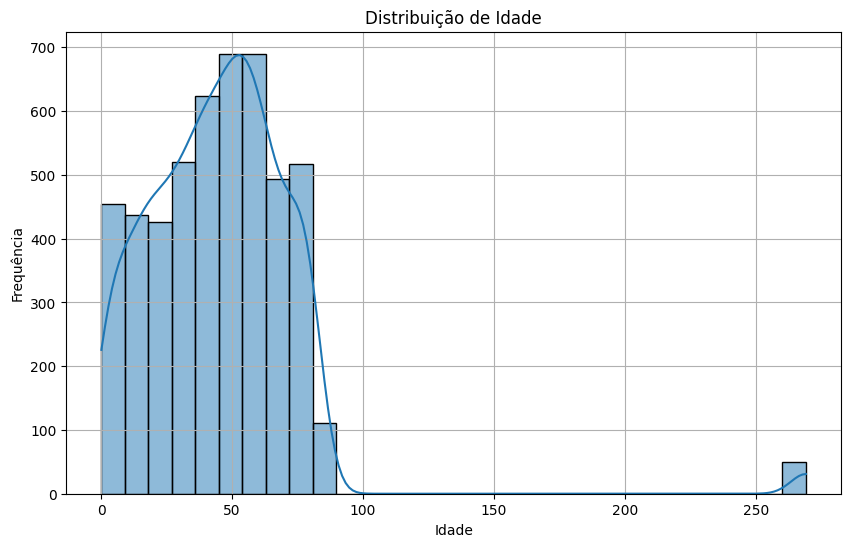

In [771]:
# [2. Extração e análise exploratória de dados - Análise exploratória]

# Distribuição de idade
plt.figure(figsize=(10, 6))
sns.histplot(stroke_df['age'], bins=30, kde=True)
plt.title('Distribuição de Idade')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

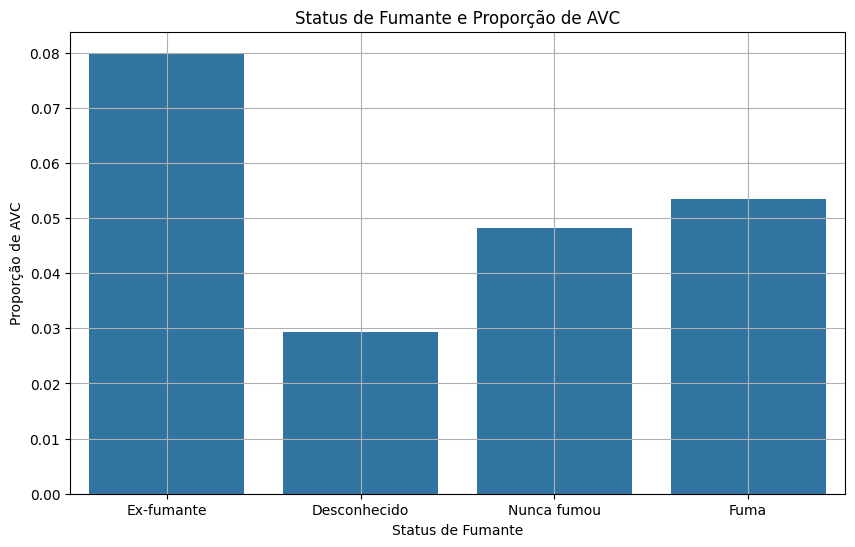

In [772]:
# [2. Extração e análise exploratória de dados - Análise exploratória]

# Status de Fumante e Proporção de AVC
plt.figure(figsize=(10, 6))
sns.barplot(x='smoking_status', y='stroke', data=stroke_df, errorbar=None)
plt.title('Status de Fumante e Proporção de AVC')
plt.xlabel('Status de Fumante')
plt.ylabel('Proporção de AVC')
plt.grid(True)
plt.xticks(ticks=['never smoked', 'formerly smoked', 'smokes', 'Unknown'], labels=['Nunca fumou', 'Ex-fumante', 'Fuma', 'Desconhecido'])
plt.show()

In [773]:
# [2. Extração e análise exploratória de dados - Tratamento de inconsistências]

# Identificando outliers em 'age' e 'bmi'
age_outliers = stroke_df['age'].between(stroke_df['age'].quantile(0.05), stroke_df['age'].quantile(0.95))
bmi_outliers = stroke_df['bmi'].between(stroke_df['bmi'].quantile(0.05), stroke_df['bmi'].quantile(0.95))

# Substituindo outliers por NaN para tratá-los como valores faltantes
stroke_df.loc[~age_outliers, 'age'] = np.nan
stroke_df.loc[~bmi_outliers, 'bmi'] = np.nan

# Codificar colunas categóricas
label_encoders = {}
categorical_columns = ['smoking_status', 'ever_married', 'residence_type', 'gender']

for column in categorical_columns:
    le = LabelEncoder()
    stroke_df[column] = le.fit_transform(stroke_df[column].astype(str))
    label_encoders[column] = le

# Separar as colunas que serão usadas na imputação
age_imputation_columns = ['age', 'smoking_status', 'bmi', 'ever_married', 'hypertension', 'residence_type', 'avg_glucose_level']
smoking_status_imputation_columns = ['smoking_status', 'gender', 'age', 'heart_disease', 'ever_married', 'residence_type']
bmi_imputation_columns = ['bmi', 'gender', 'age', 'hypertension', 'heart_disease', 'residence_type', 'avg_glucose_level']

# Preenchendo 'age' com base em registros similares
age_imputer = KNNImputer(n_neighbors=5)
stroke_df['age'] = age_imputer.fit_transform(stroke_df[age_imputation_columns])[:, 0]

# Preenchendo 'smoking_status' com base em registros similares
stroke_df['smoking_status'] = stroke_df['smoking_status'].replace(label_encoders['smoking_status'].transform(['Unknown'])[0], np.nan)
smoking_status_imputer = KNNImputer(n_neighbors=5)
stroke_df['smoking_status'] = smoking_status_imputer.fit_transform(stroke_df[smoking_status_imputation_columns])[:, 0]

# Preenchendo 'bmi' com base em registros similares
bmi_imputer = KNNImputer(n_neighbors=5)
stroke_df['bmi'] = bmi_imputer.fit_transform(stroke_df[bmi_imputation_columns])[:, 0]

# Decodificar colunas categóricas
for column, le in label_encoders.items():
    stroke_df[column] = le.inverse_transform(stroke_df[column].astype(int))

# Verificar se ainda há valores faltantes
missing_values = stroke_df.isnull().sum()

# Exibir o resultado
print(missing_values)

stroke_df.describe()


id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5059.000000,5059.000000,5059.000000,5059.000000,5059.000000,5059.000000,5059.000000
mean,36525.255584,42.850563,0.097648,0.053568,106.090976,28.499178,0.048824
std,21182.877390,20.271804,0.296867,0.225185,45.209029,5.871091,0.215521
min,67.000000,5.000000,0.000000,0.000000,55.120000,17.700000,0.000000
25%,17721.500000,26.000000,0.000000,0.000000,77.250000,24.100000,0.000000
50%,36946.000000,44.000000,0.000000,0.000000,91.850000,28.100000,0.000000
75%,54762.500000,59.000000,0.000000,0.000000,114.015000,32.300000,0.000000
max,72940.000000,79.000000,1.000000,1.000000,271.740000,43.900000,1.000000


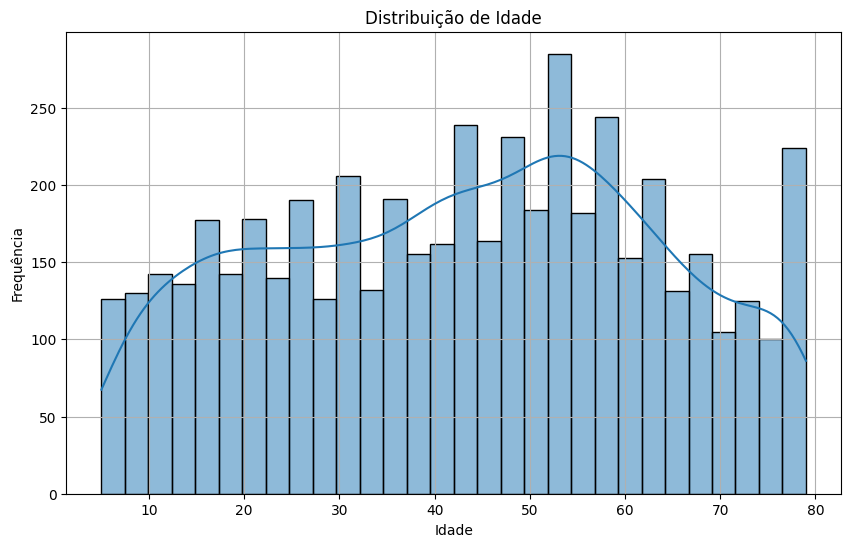

In [774]:
# [2. Extração e análise exploratória de dados - Análise exploratória]

# Distribuição de idade - Revendo após tratamentos
plt.figure(figsize=(10, 6))
sns.histplot(stroke_df['age'], bins=30, kde=True)
plt.title('Distribuição de Idade')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

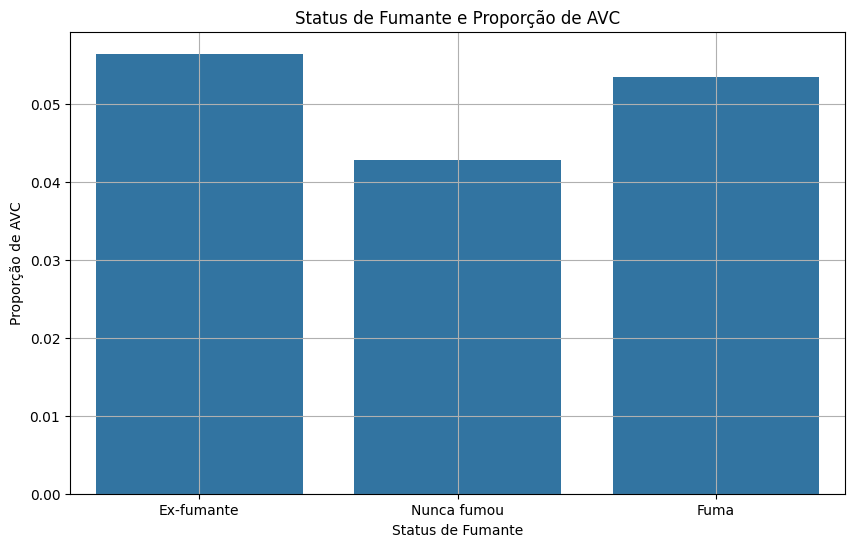

In [775]:
# [2. Extração e análise exploratória de dados - Análise exploratória]

# Status de Fumante e Proporção de AVC - Revendo após tratamento
plt.figure(figsize=(10, 6))
sns.barplot(x='smoking_status', y='stroke', data=stroke_df, errorbar=None)
plt.title('Status de Fumante e Proporção de AVC')
plt.xlabel('Status de Fumante')
plt.ylabel('Proporção de AVC')
plt.grid(True)
plt.xticks(ticks=['never smoked', 'formerly smoked', 'smokes'], labels=['Nunca fumou', 'Ex-fumante', 'Fuma'])
plt.show()

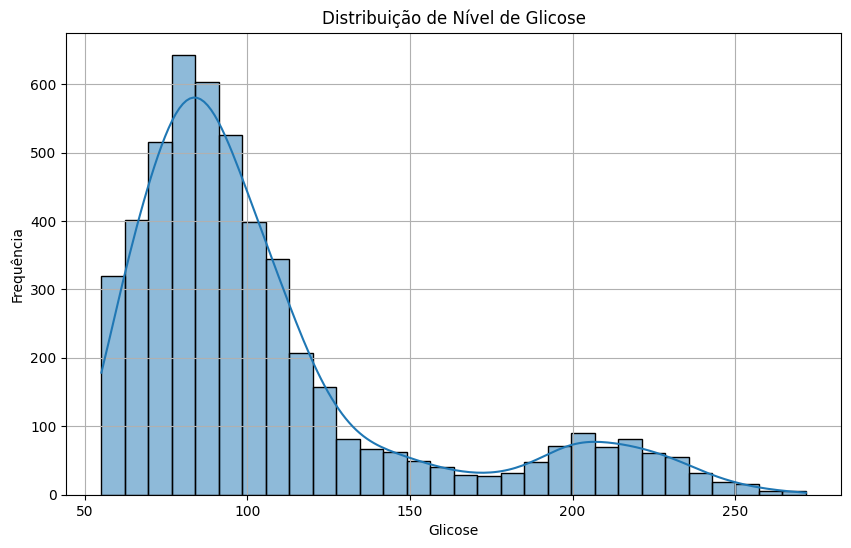

In [776]:
# [2. Extração e análise exploratória de dados - Análise exploratória]

# Distribuição de nível de glicose
plt.figure(figsize=(10, 6))
sns.histplot(stroke_df['avg_glucose_level'], bins=30, kde=True)
plt.title('Distribuição de Nível de Glicose')
plt.xlabel('Glicose')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

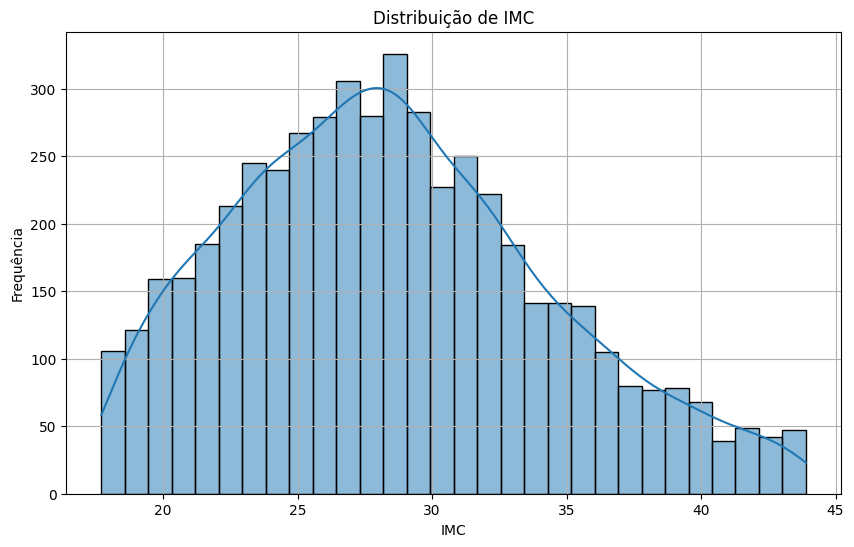

In [777]:
# [2. Extração e análise exploratória de dados - Análise exploratória]

# Distribuição de IMC
plt.figure(figsize=(10, 6))
sns.histplot(stroke_df['bmi'], bins=30, kde=True)
plt.title('Distribuição de IMC')
plt.xlabel('IMC')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

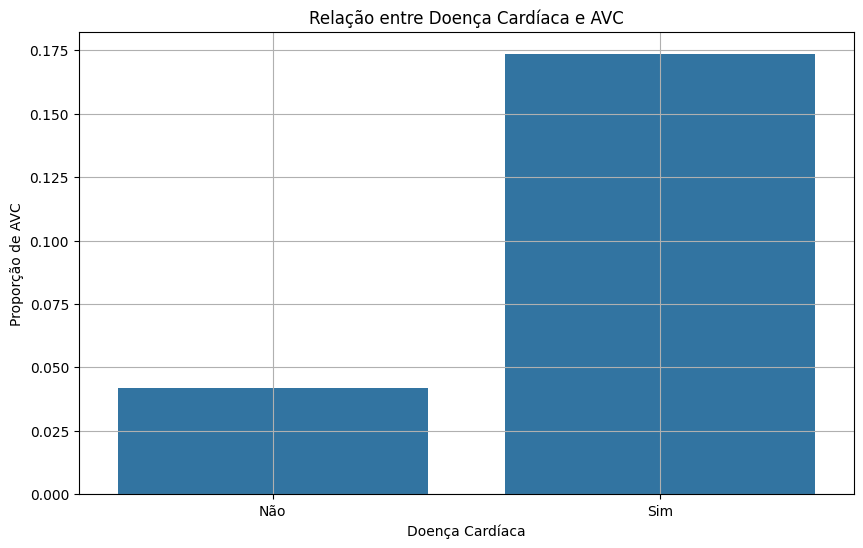

In [778]:
# [2. Extração e análise exploratória de dados - Análise exploratória]

# Gráfico de barras para Doença Cardíaca e AVC
plt.figure(figsize=(10, 6))
sns.barplot(x='heart_disease', y='stroke', data=stroke_df, errorbar=None)
plt.title('Relação entre Doença Cardíaca e AVC')
plt.xlabel('Doença Cardíaca')
plt.ylabel('Proporção de AVC')
plt.grid(True)
plt.xticks(ticks=[0, 1], labels=['Não', 'Sim'])
plt.show()

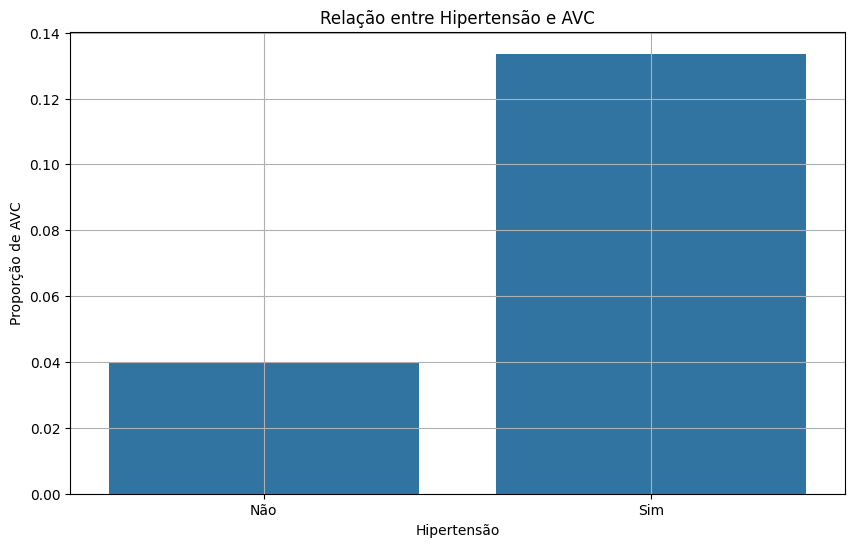

In [779]:
# [2. Extração e análise exploratória de dados - Análise exploratória]

# Gráfico de barras para Hipertensão e AVC
plt.figure(figsize=(10, 6))
sns.barplot(x='hypertension', y='stroke', data=stroke_df, errorbar=None)
plt.title('Relação entre Hipertensão e AVC')
plt.xlabel('Hipertensão')
plt.ylabel('Proporção de AVC')
plt.grid(True)
plt.xticks(ticks=[0, 1], labels=['Não', 'Sim'])
plt.show()

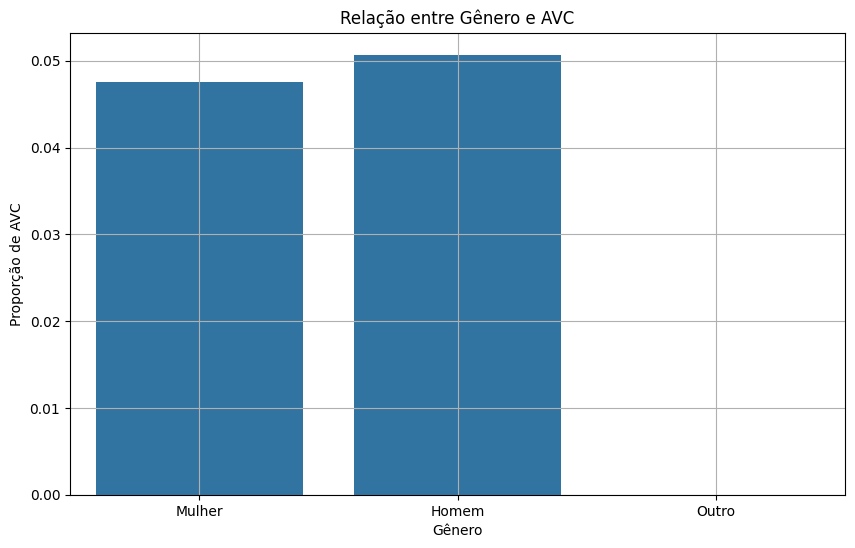

In [780]:
# [2. Extração e análise exploratória de dados - Análise exploratória]

# Gráfico de barras para Gênero e AVC
plt.figure(figsize=(10, 6))
sns.barplot(x='gender', y='stroke', data=stroke_df, errorbar=None)
plt.title('Relação entre Gênero e AVC')
plt.xlabel('Gênero')
plt.ylabel('Proporção de AVC')
plt.grid(True)
plt.xticks(ticks=['Male', 'Female', 'Other'], labels=['Homem', 'Mulher', 'Outro'])
plt.show()

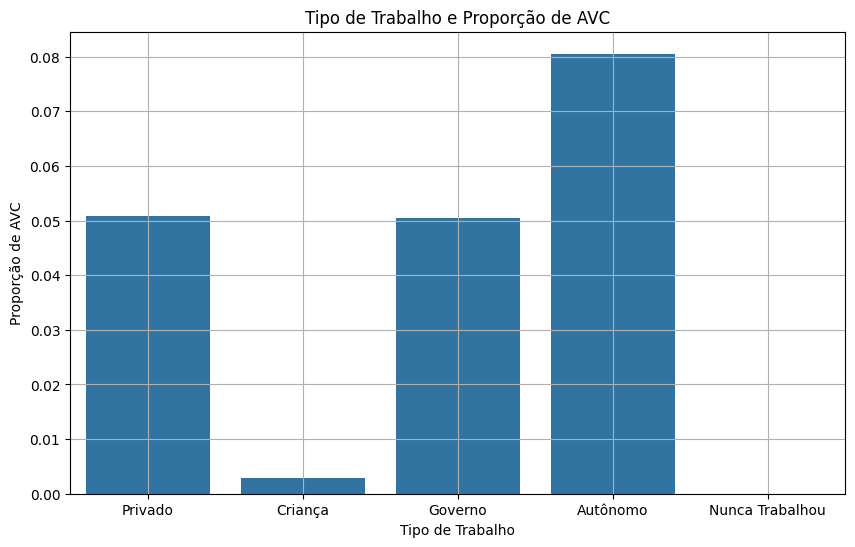

In [781]:
# [2. Extração e análise exploratória de dados - Análise exploratória]

# Tipo de Trabalho e Proporção de AVC
plt.figure(figsize=(10, 6))
sns.barplot(x='work_type', y='stroke', data=stroke_df, errorbar=None)
plt.title('Tipo de Trabalho e Proporção de AVC')
plt.xlabel('Tipo de Trabalho')
plt.ylabel('Proporção de AVC')
plt.grid(True)
plt.xticks(ticks=['Private', 'children', 'Govt_job', 'Self-employed', 'Never_worked'], labels=['Privado', 'Criança', 'Governo', 'Autônomo', 'Nunca Trabalhou'])
plt.show()

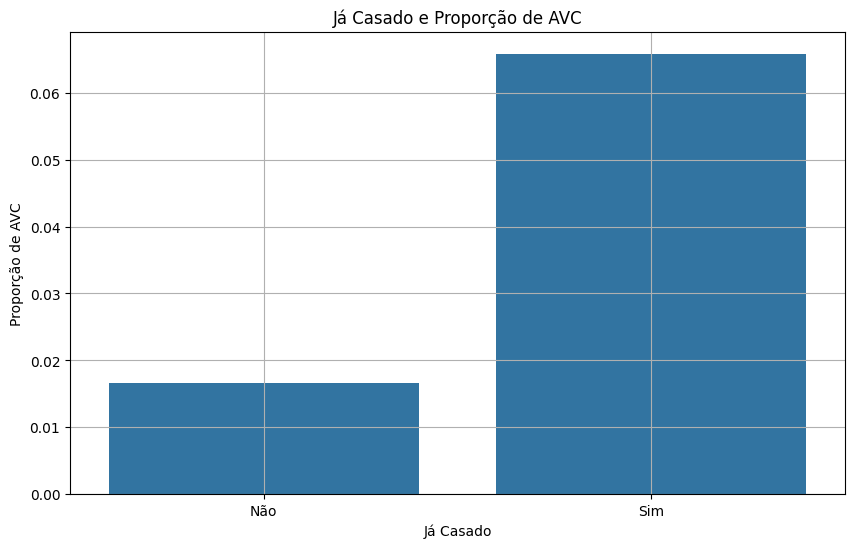

In [782]:
# [2. Extração e análise exploratória de dados - Análise exploratória]

# Já Casado e Proporção de AVC
plt.figure(figsize=(10, 6))
sns.barplot(x='ever_married', y='stroke', data=stroke_df, errorbar=None)
plt.title('Já Casado e Proporção de AVC')
plt.xlabel('Já Casado')
plt.ylabel('Proporção de AVC')
plt.grid(True)
plt.xticks(ticks=['No', 'Yes'], labels=['Não', 'Sim'])
plt.show()

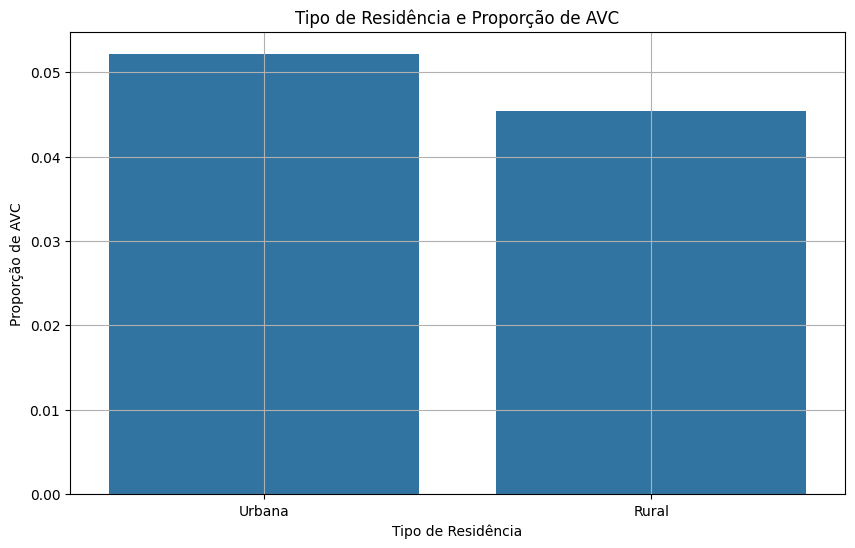

In [783]:
# [2. Extração e análise exploratória de dados - Análise exploratória]

# Tipo de Residência e Proporção de AVC
plt.figure(figsize=(10, 6))
sns.barplot(x='residence_type', y='stroke', data=stroke_df, errorbar=None)
plt.title('Tipo de Residência e Proporção de AVC')
plt.xlabel('Tipo de Residência')
plt.ylabel('Proporção de AVC')
plt.grid(True)
plt.xticks(ticks=['Urban', 'Rural'], labels=['Urbana', 'Rural'])
plt.show()

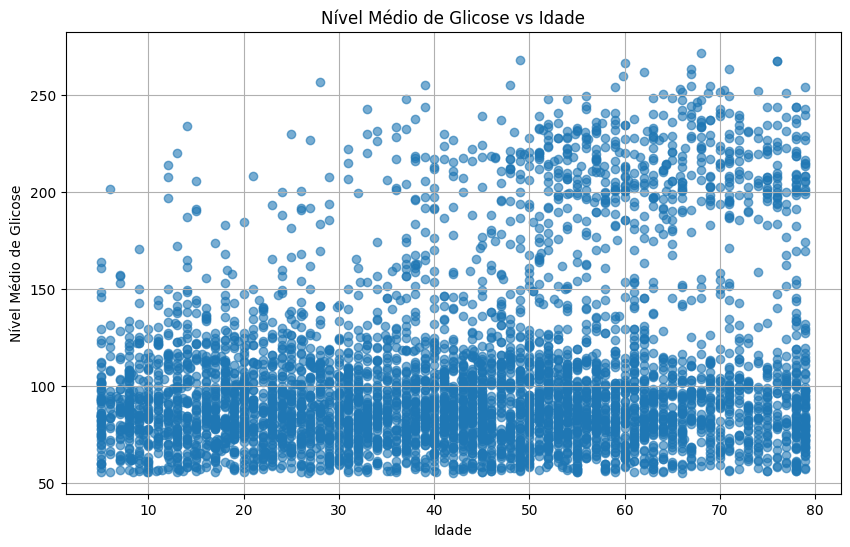

In [784]:
# [2. Extração e análise exploratória de dados - Análise exploratória]

# Nível Médio de Glicose vs. Idade
plt.figure(figsize=(10, 6))
plt.scatter(stroke_df['age'], stroke_df['avg_glucose_level'], alpha=0.6)
plt.title('Nível Médio de Glicose vs Idade')
plt.xlabel('Idade')
plt.ylabel('Nível Médio de Glicose')
plt.grid(True)
plt.show()

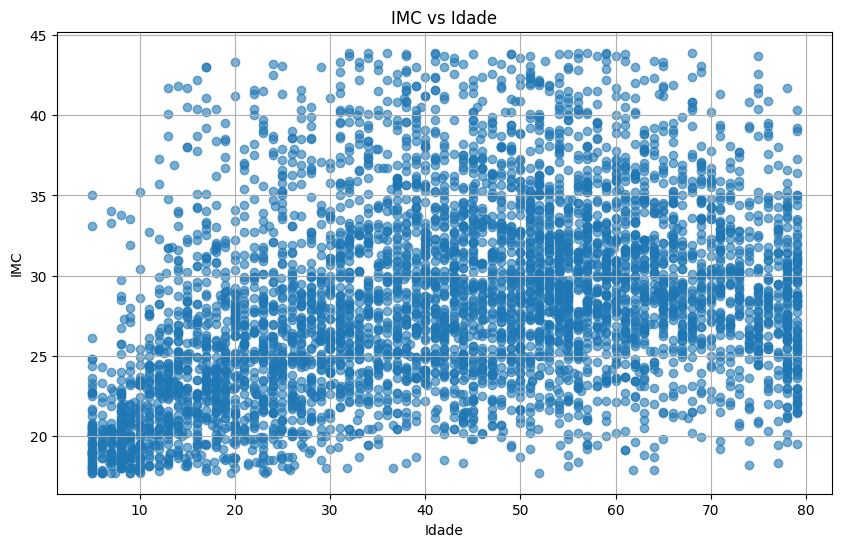

In [785]:
# [2. Extração e análise exploratória de dados - Análise exploratória]

# Gráfico de dispersão para Nível de Glicose vs Idade
plt.figure(figsize=(10, 6))
plt.scatter(stroke_df['age'], stroke_df['bmi'], alpha=0.6)
plt.title('IMC vs Idade')
plt.xlabel('Idade')
plt.ylabel('IMC')
plt.grid(True)
plt.show()


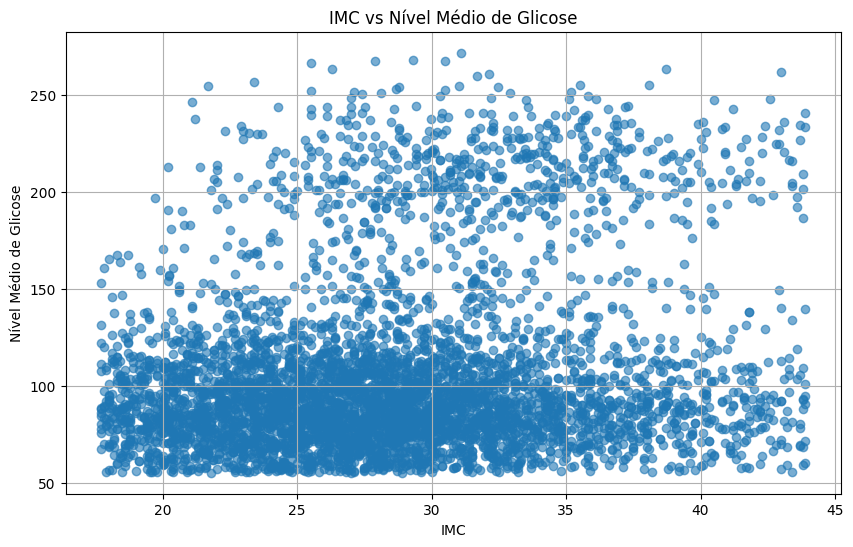

In [786]:
# [2. Extração e análise exploratória de dados - Análise exploratória]

# Nível Médio de Glicose vs. IMC
plt.figure(figsize=(10, 6))
plt.scatter(stroke_df['bmi'], stroke_df['avg_glucose_level'], alpha=0.6)
plt.title('IMC vs Nível Médio de Glicose')
plt.xlabel('IMC')
plt.ylabel('Nível Médio de Glicose')
plt.grid(True)
plt.show()

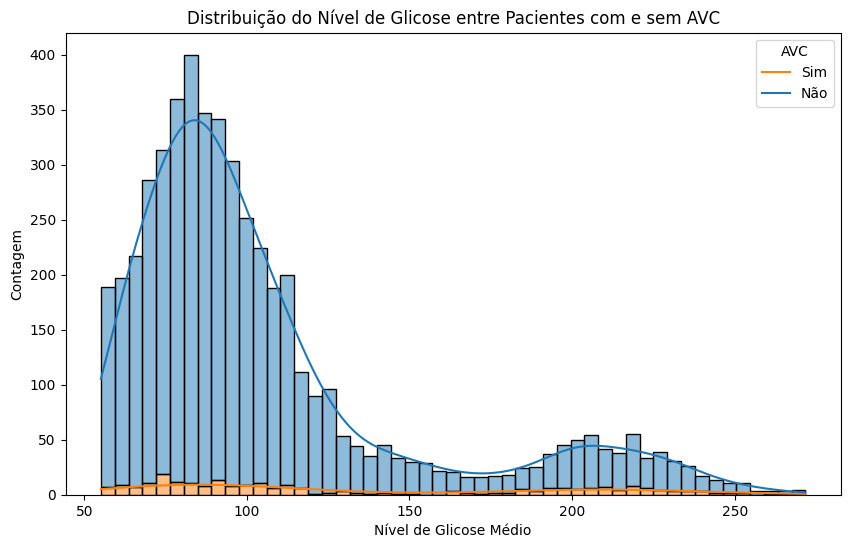

In [787]:
# [2. Extração e análise exploratória de dados - Análise exploratória]

# Histograma da distribuição do nível de glicose entre pacientes com e sem AVC
plt.figure(figsize=(10, 6))
sns.histplot(data=stroke_df, x='avg_glucose_level', hue='stroke', multiple='stack', kde=True)
plt.title('Distribuição do Nível de Glicose entre Pacientes com e sem AVC')
plt.xlabel('Nível de Glicose Médio')
plt.ylabel('Contagem')
plt.legend(title='AVC', labels=['Sim', 'Não'])
plt.show()

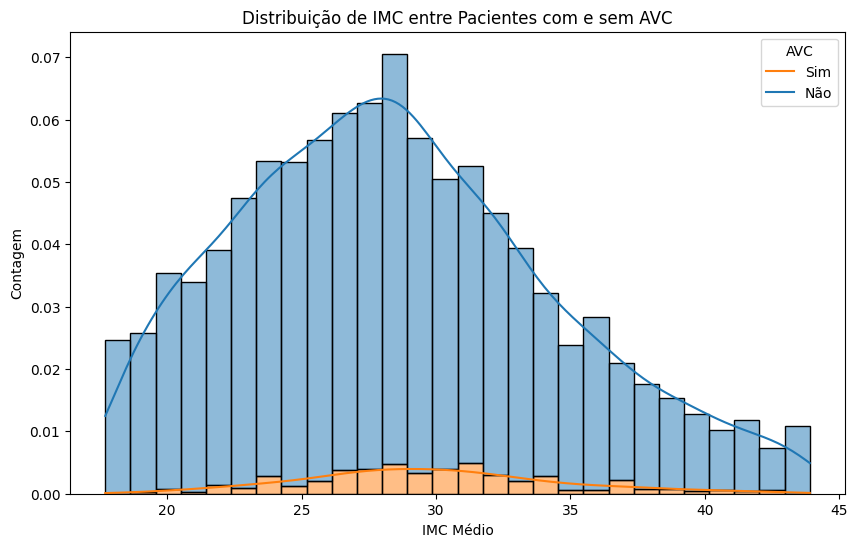

In [788]:
# [2. Extração e análise exploratória de dados - Análise exploratória]

# Histograma da distribuição do IMC entre pacientes com e sem AVC
plt.figure(figsize=(10, 6))
sns.histplot(data=stroke_df, x='bmi', hue='stroke', multiple='stack', kde=True, stat='probability')
plt.title('Distribuição de IMC entre Pacientes com e sem AVC')
plt.xlabel('IMC Médio')
plt.ylabel('Contagem')
plt.legend(title='AVC', labels=['Sim', 'Não'])
plt.show()


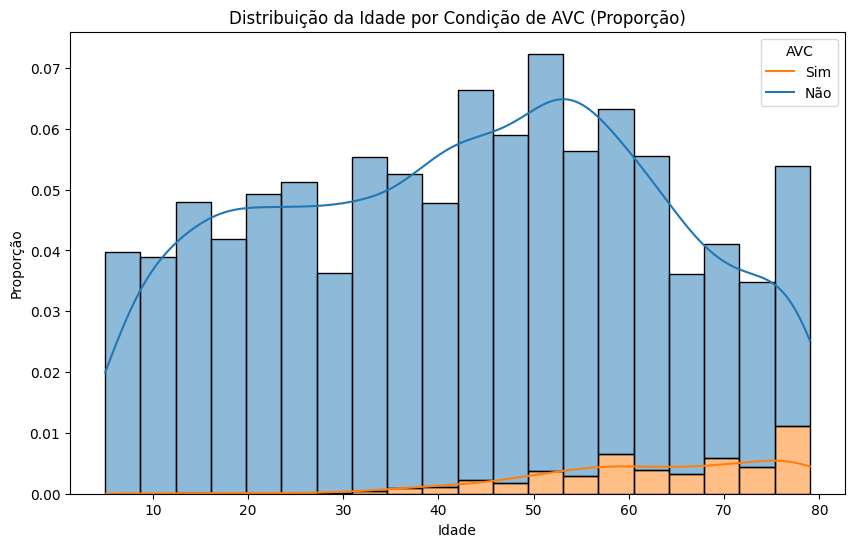

In [789]:
plt.figure(figsize=(10, 6))
sns.histplot(data=stroke_df, x='age', hue='stroke', multiple='stack', kde=True, stat='probability')
plt.title('Distribuição da Idade por Condição de AVC (Proporção)')
plt.xlabel('Idade')
plt.ylabel('Proporção')
plt.legend(title='AVC', labels=['Sim', 'Não'])
plt.show()

In [790]:
# [2. Extração e análise exploratória de dados - Análise exploratória]

graph = px.scatter_matrix(
    stroke_df, 
    dimensions=['age', 'avg_glucose_level', 'bmi'], 
    color='stroke',
    labels={
        'age': 'Idade',
        'avg_glucose_level': 'Nív Méd. de Glic.',
        'bmi': 'IMC',
        'stroke': 'AVC'
    }
)
graph.show()

In [791]:
# [2. Extração e análise exploratória de dados - Análise exploratória]

graph = px.scatter_matrix(
    stroke_df, 
    dimensions=['age', 'avg_glucose_level', 'bmi'], 
    color='hypertension',
    labels={
        'age': 'Idade',
        'avg_glucose_level': 'Nív. Méd. Glic.',
        'bmi': 'IMC',
        'hypertension': 'Hipert.'
    }
)

graph.show()

In [792]:
# [2. Extração e análise exploratória de dados - Análise exploratória]

heart_disease_map = {0: 'Não', 1: 'Sim'}
hypertension_map = {0: 'Não', 1: 'Sim'}
ever_married_map = {'No': 'Não', 'Yes': 'Sim'}
smoking_status_map = {
    'never smoked': 'Nunca fumou', 
    'formerly smoked': 'Ex-fumante', 
    'smokes': 'Fuma', 
    'Unknown': 'Desconhecido'
}
work_type_map = {
    'children': 'Crianças', 
    'Govt_job': 'Trabalho Governamental', 
    'Never_worked': 'Nunca Trabalhou', 
    'Private': 'Privado', 
    'Self-employed': 'Autônomo'
}
stroke_map = {0: 'Não', 1: 'Sim'}

graph = px.parallel_categories(
    stroke_df.replace({
        'heart_disease': heart_disease_map,
        'hypertension': hypertension_map,
        'ever_married': ever_married_map,
        'smoking_status': smoking_status_map,
        'work_type': work_type_map,
        'stroke': stroke_map
    }), 
    dimensions=['heart_disease', 'hypertension', 'ever_married', 'smoking_status', 'work_type', 'stroke'],
    labels={
        'heart_disease': 'Doença Cardíaca',
        'hypertension': 'Hipertensão',
        'ever_married': 'Já Casado',
        'smoking_status': 'Status de Fumante',
        'work_type': 'Tipo de Trabalho',
        'stroke': 'AVC'
    }
)

graph.show()


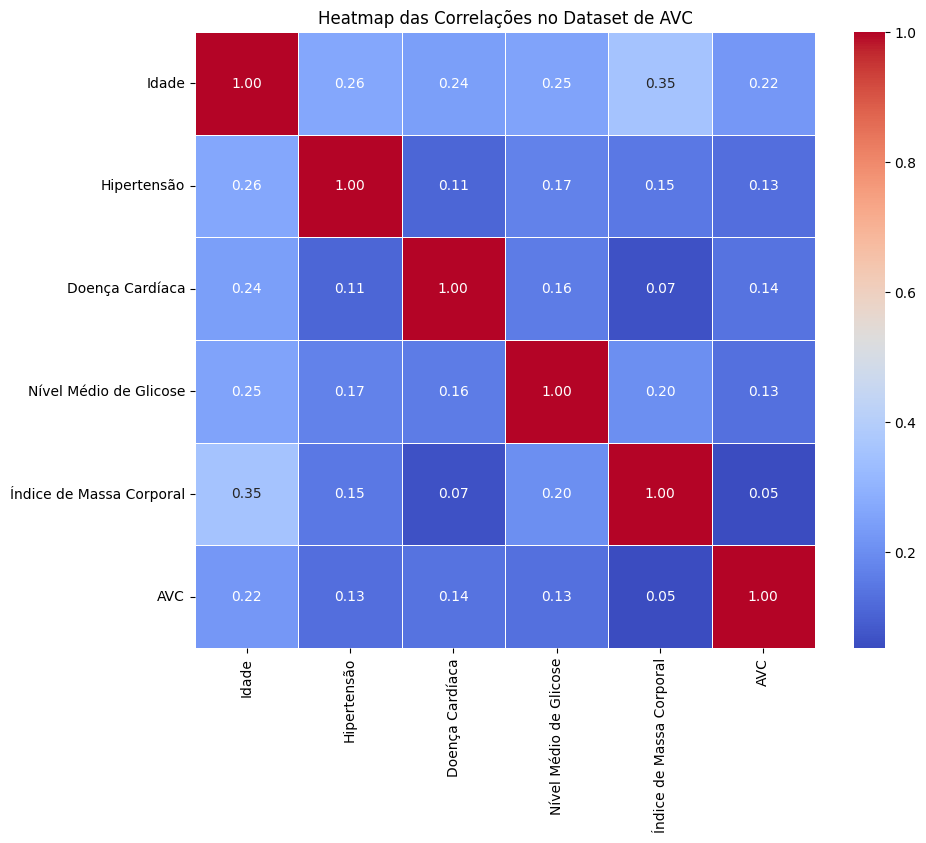

In [793]:
# [2. Extração e análise exploratória de dados - Análise exploratória]

selected_columns = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']
correlation_matrix = stroke_df[selected_columns].corr()
column_names_translation = {
    'age': 'Idade',
    'hypertension': 'Hipertensão',
    'heart_disease': 'Doença Cardíaca',
    'avg_glucose_level': 'Nível Médio de Glicose',
    'bmi': 'Índice de Massa Corporal',
    'stroke': 'AVC'
}
correlation_matrix.rename(columns=column_names_translation, index=column_names_translation, inplace=True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap das Correlações no Dataset de AVC')
plt.show()

In [794]:
# [3. Preprocessamento - Padronização e Normalização]

stroke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5059 entries, 0 to 5058
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5059 non-null   int64  
 1   gender             5059 non-null   object 
 2   age                5059 non-null   float64
 3   hypertension       5059 non-null   int64  
 4   heart_disease      5059 non-null   int64  
 5   ever_married       5059 non-null   object 
 6   work_type          5059 non-null   object 
 7   residence_type     5059 non-null   object 
 8   avg_glucose_level  5059 non-null   float64
 9   bmi                5059 non-null   float64
 10  smoking_status     5059 non-null   object 
 11  stroke             5059 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 474.4+ KB


In [795]:
# [3. Preprocessamento - Padronização e Normalização]

X_stroke_df_processed = stroke_df.drop(columns=['id', 'stroke'], axis=1)
y_stroke_df = stroke_df['stroke']

# Identificando colunas categóricas e numéricas para aplicação de transformações apropriadas
categorical_cols = X_stroke_df_processed.select_dtypes(include=['object']).columns
numerical_cols = X_stroke_df_processed.select_dtypes(include=['float64', 'int64']).columns

# Definindo o pré-processador utilizando ColumnTransformer para aplicar transformações diferentes em colunas diferentes
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols), # Padroniza as colunas numéricas para terem média zero e desvio padrão um
        ('cat', OneHotEncoder(), categorical_cols) # Transforma as colunas categóricas em uma matriz esparsa de variáveis binárias
    ])

# Aplicando o pré-processador
data_preprocessed = preprocessor.fit_transform(X_stroke_df_processed)

# Convertendo o array de volta para um DataFrame
encoded_categorical_cols = preprocessor.transformers_[1][1].get_feature_names_out(categorical_cols)
all_columns = list(numerical_cols) + list(encoded_categorical_cols)
X_stroke_df_processed = pd.DataFrame(data_preprocessed, columns=all_columns)


In [796]:
# [3. Preprocessamento - Divisão do Conjunto]

# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_stroke_df_processed, y_stroke_df, test_size=0.2, random_state=33)


In [797]:
# [3. Preprocessamento - Divisão do Conjunto]

print("Dados de Treino - Previsores:")
X_train.head(5)

Dados de Treino - Previsores:


,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
1466,0.007372,-0.328960,-0.237907,-0.282958,0.715580,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3678,0.056707,-0.328960,-0.237907,-0.939971,1.499158,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4768,0.895393,3.039883,-0.237907,-0.876703,0.511169,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
816,-0.091297,-0.328960,-0.237907,-0.160182,-0.664197,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3125,-0.140631,-0.328960,-0.237907,-0.751494,1.618398,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [798]:
# [3. Preprocessamento - Divisão do Conjunto]

print("Dados de Treino - Classe:")
y_train.head(5)

Dados de Treino - Classe:


1466    0
3678    0
4768    0
816     0
3125    0
Name: stroke, dtype: int64

In [799]:
# [3. Preprocessamento - Divisão do Conjunto]

print("Dados de Teste - Previsores:")
X_test.head(5)

Dados de Teste - Previsores:


,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
3821,-0.239300,-0.328960,-0.237907,-0.580936,-0.102066,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1098,0.106041,-0.328960,-0.237907,0.096871,-0.647163,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2058,-1.265457,-0.328960,-0.237907,-0.791092,-0.173610,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1141,-1.472662,-0.328960,-0.237907,-0.297337,0.545237,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4652,-0.337969,3.039883,-0.237907,-0.321449,2.333838,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [800]:
# [3. Preprocessamento - Divisão do Conjunto]

print("Dados de Teste - Classe:")
y_test.head(5)

Dados de Teste - Classe:


3821    0
1098    0
2058    0
1141    0
4652    0
Name: stroke, dtype: int64

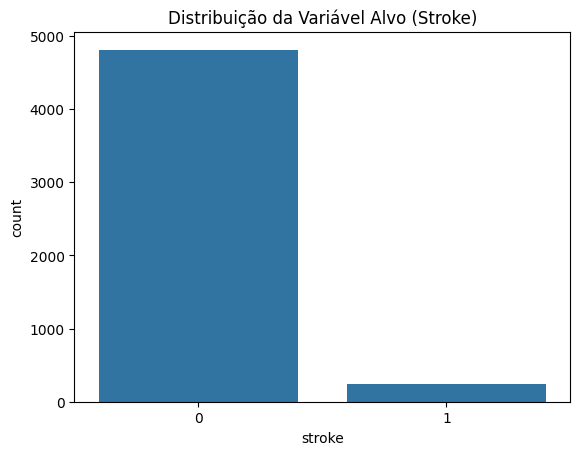

In [801]:
# [5. Treinamento e Validação - Treinamento do Modelo]

sns.countplot(x=y_stroke_df)
plt.title("Distribuição da Variável Alvo (Stroke)")
plt.show()

In [802]:
# [5. Treinamento e Validação - Treinamento do Modelo]

# Criando uma instância do modelo de regressão logística
log_reg = LogisticRegression()

# Definindo a grade de parâmetros para busca
param_grid = {
    'solver': ['liblinear', 'lbfgs'],
    'class_weight': ['balanced', None],
    'C': [0.1, 1, 10, 100]
}

# Executando GridSearchCV para encontrar os melhores hiperparâmetros
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado
best_log_reg = grid_search.best_estimator_

In [803]:
# [5. Treinamento e Validação - Validação do Modelo]

# Avaliando a regressão logística com validação cruzada e calculando a média das acurácias
cross_val_score(log_reg, X_stroke_df_processed, y_stroke_df).mean()

np.float64(0.9511761923192706)

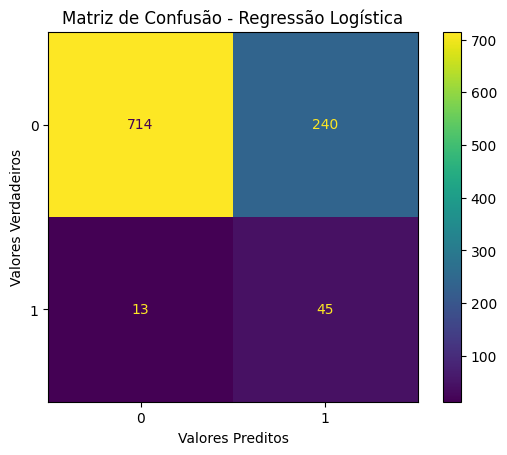

In [804]:
# [5. Treinamento e Validação - Validação do Modelo]

y_pred_log_reg = best_log_reg.predict(X_test)

cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
disp_log_reg = ConfusionMatrixDisplay(confusion_matrix=cm_log_reg)
disp_log_reg.plot()
plt.title("Matriz de Confusão - Regressão Logística")
plt.xlabel("Valores Preditos")
plt.ylabel("Valores Verdadeiros")
plt.show()


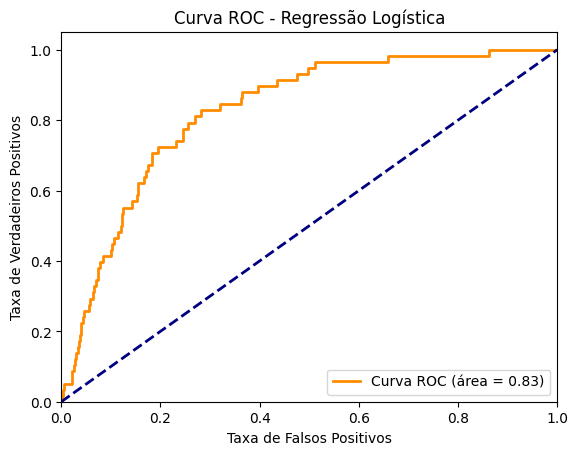

In [805]:
# [5. Treinamento e Validação - Validação do Modelo]

y_prob_log_reg = best_log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_log_reg)
roc_auc = roc_auc_score(y_test, y_prob_log_reg)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Regressão Logística')
plt.legend(loc="lower right")
plt.show()
